# MovieLens MLN Recommendation via PyTorch

adapted from https://github.com/fastai/fastai

In [23]:
import math
import copy
import os
import pickle
from itertools import zip_longest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim

import time

figure_path = '/home/weiss/git/thesis/doc/figures/'

In [24]:
# make experiment repeatable

def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

RANDOM_STATE = 2021
set_random_seed(RANDOM_STATE)

In [25]:
# import and preprocess data

dataset = 'goodreads'
DIR = '/home/weiss/rs_data/goodreads/'
PATH_IN = os.path.join(DIR, 'goodreads_interactions.csv')
ratings = pd.read_csv(PATH_IN)
ratings = ratings[ratings['rating'] != 0]  # drop empty reviews
ratings.drop(columns=['is_read', 'is_reviewed'], inplace=True)
ratings.rename(columns={'book_id': 'item_id'}, inplace = True)

# Keep entries where the user has rated more than n items and less than m items
n = 50
m = 1000
counts = ratings['user_id'].value_counts()
mask = (counts >= n) & (counts <= m)
print(mask.value_counts())
ratings = ratings[ratings['user_id'].isin(mask[mask == True].index)]

ratings.head()

True     424154
False    392217
Name: user_id, dtype: int64


,user_id,item_id,rating
0,0,948,5
1,0,947,5
2,0,946,5
3,0,945,5
4,0,944,5


In [26]:
def create_dataset(ratings):
    unique_users = ratings.user_id.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.user_id.map(user_to_index)

    unique_items = ratings.item_id.unique()
    item_to_index = {old: new for new, old in enumerate(unique_items)}
    new_items = ratings.item_id.map(item_to_index)

    n_users = unique_users.shape[0]
    n_items = unique_items.shape[0]

    X = pd.DataFrame({'user_id': new_users, 'book_id': new_items})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_items), (X, y), (user_to_index, item_to_index)

(n, m), (X, y), _ = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} items')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 424154 users, 2116340 items
Dataset shape: (81569320, 2)
Target shape: (81569320,)


In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid), 'test': (X_test, y_test)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid), 'test': len(X_test)}


In [28]:
class RatingsIterator:

    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [29]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in RatingsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [30]:
class RecommenderNet(nn.Module):
    """
    Creates dense MLN with embedding layers.

    Args:
        n_users:
            Number of unique users in the dataset.

        n_items:
            Number of unique item in the dataset.

        n_factors:
            Number of columns in the embeddings matrix.

        embedding_dropout:
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of
            units in hidden layer(s).

        dropouts:
            A single integer or a list of integers defining the dropout
            layers rates applied right after each of hidden layers.

    """
    def __init__(self, n_users, n_items,
                 n_factors=50, embedding_dropout=0.02,
                 hidden=10, dropouts=0.2):

        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]

        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and
            their activations/dropouts.

            Note that the function captures `hidden` and `dropouts`
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)

            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out

        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_items, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self.relu = nn.ReLU()
        self._init()

    def forward(self, users, items, minmax=None):
        features = torch.cat([self.u(users), self.m(items)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        #out = self.relu(self.fc(x))  # relu delivers worse rsme
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out

    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """

        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)


def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [31]:
minmax = float(ratings.rating.min()), float(ratings.rating.max())
minmax

(1.0, 5.0)

In [32]:
# small net

start = time.time()
net = RecommenderNet(
    n_users=n, n_items=m,
    n_factors=10, hidden=[10],
    embedding_dropout=0.05, dropouts=[0.3])

In [33]:
lr = 1e-3
wd = 1e-5
bs = 4096
n_epochs = 30
patience = 30
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

In [34]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}

    for phase in ('train', 'val'):
        if phase == 'train':
          training = True
        else:
          training = False
        running_loss = 0
        n_batches = 0
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)
                # don't update weights and rates when in 'val' phase
                if training:
                    #scheduler.step()
                    loss.backward()
                    optimizer.step()
                    #lr_history.extend(scheduler.get_lr())
            running_loss += loss.item()
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
    history.append(stats)
    with open(f'logs/small.txt', 'a') as f:
        print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
        f.write('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

loss improvement on epoch: 1
[001/030] train: 0.7802 - val: 0.7431
loss improvement on epoch: 2
[002/030] train: 0.7267 - val: 0.7367
loss improvement on epoch: 3
[003/030] train: 0.7151 - val: 0.7348
loss improvement on epoch: 4
[004/030] train: 0.7083 - val: 0.7341
loss improvement on epoch: 5
[005/030] train: 0.7037 - val: 0.7336
[006/030] train: 0.7002 - val: 0.7336
loss improvement on epoch: 7
[007/030] train: 0.6973 - val: 0.7335
loss improvement on epoch: 8
[008/030] train: 0.6949 - val: 0.7334
[009/030] train: 0.6930 - val: 0.7336
loss improvement on epoch: 10
[010/030] train: 0.6913 - val: 0.7332
[011/030] train: 0.6900 - val: 0.7334
[012/030] train: 0.6888 - val: 0.7337
loss improvement on epoch: 13
[013/030] train: 0.6877 - val: 0.7332
[014/030] train: 0.6868 - val: 0.7334
loss improvement on epoch: 15
[015/030] train: 0.6860 - val: 0.7331
[016/030] train: 0.6853 - val: 0.7337
[017/030] train: 0.6848 - val: 0.7337
[018/030] train: 0.6842 - val: 0.7337
[019/030] train: 0.6836

In [35]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [36]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [37]:
valid_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Validation RMSE: {valid_loss:.4f}')

Validation RMSE: 0.8562


In [38]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['test'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [39]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Small Test RMSE: {final_loss:.4f}')

Small Test RMSE: 0.8563


In [40]:
print(f'Small duration: {round(time.time() - start, 4)}')

Small duration: 4876.7362


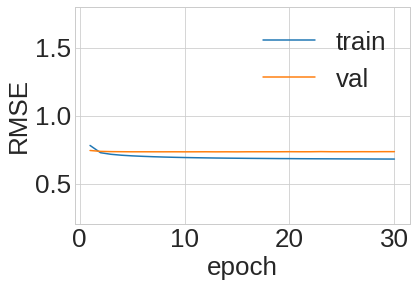

In [41]:
plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['legend.fontsize'] = 26
plt.style.use('seaborn-whitegrid')
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')
plt.ylabel('RMSE')
plt.ylim([0.2, 1.8])

plt.savefig(figure_path + '/' + dataset +'-small-loss.png', dpi=300, bbox_inches='tight')


In [42]:
with open('best.weights.small', 'wb') as file:
    pickle.dump(best_weights, file)

In [43]:
# medium net

start = time.time()
net = RecommenderNet(
    n_users=n, n_items=m,
    n_factors=20, hidden=[10 ,10],
    embedding_dropout=0.05, dropouts=[0.3, 0.3])

In [44]:
lr = 1e-3
wd = 1e-5
bs = 4096
n_epochs = 30
patience = 30
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

In [45]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}

    for phase in ('train', 'val'):
        if phase == 'train':
          training = True
        else:
          training = False
        running_loss = 0
        n_batches = 0
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)
                # don't update weights and rates when in 'val' phase
                if training:
                    #scheduler.step()
                    loss.backward()
                    optimizer.step()
                    #lr_history.extend(scheduler.get_lr())
            running_loss += loss.item()
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
    history.append(stats)
    with open(f'logs/medium.txt', 'a') as f:
        print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
        f.write('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

loss improvement on epoch: 1
[001/030] train: 0.7860 - val: 0.7547
loss improvement on epoch: 2
[002/030] train: 0.7387 - val: 0.7478
loss improvement on epoch: 3
[003/030] train: 0.7267 - val: 0.7451
loss improvement on epoch: 4
[004/030] train: 0.7197 - val: 0.7438
loss improvement on epoch: 5
[005/030] train: 0.7150 - val: 0.7438
[006/030] train: 0.7115 - val: 0.7439
[007/030] train: 0.7087 - val: 0.7438
loss improvement on epoch: 8
[008/030] train: 0.7063 - val: 0.7432
[009/030] train: 0.7043 - val: 0.7438
[010/030] train: 0.7026 - val: 0.7439
[011/030] train: 0.7011 - val: 0.7440
[012/030] train: 0.6999 - val: 0.7442
[013/030] train: 0.6988 - val: 0.7441
[014/030] train: 0.6977 - val: 0.7449
[015/030] train: 0.6968 - val: 0.7448
[016/030] train: 0.6955 - val: 0.7445
[017/030] train: 0.6940 - val: 0.7448
[018/030] train: 0.6931 - val: 0.7444
[019/030] train: 0.6926 - val: 0.7451
[020/030] train: 0.6920 - val: 0.7456
[021/030] train: 0.6915 - val: 0.7460
[022/030] train: 0.6910 - va

In [46]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [47]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [48]:
valid_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Validation RMSE: {valid_loss:.4f}')

Validation RMSE: 0.8623


In [49]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['test'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [50]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Medium test RMSE: {final_loss:.4f}')

Medium test RMSE: 0.8624


In [51]:
print(f'Medium duration: {round(time.time() - start, 4)}')

Medium duration: 9314.5346


In [52]:
with open('best.weights.medium', 'wb') as file:
    pickle.dump(best_weights, file)

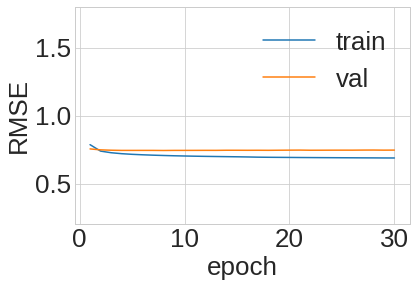

In [53]:
plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['legend.fontsize'] = 26
plt.style.use('seaborn-whitegrid')
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')
plt.ylabel('RMSE')
plt.ylim([0.2, 1.8])

plt.savefig(figure_path + '/' + dataset +'-medium-loss.png', dpi=300, bbox_inches='tight')

In [54]:
# large net

start = time.time()
net = RecommenderNet(
    n_users=n, n_items=m,
    n_factors=50, hidden=[100, 100, 100],
    embedding_dropout=0.05, dropouts=[0.3, 0.3, 0.3])

In [55]:
lr = 1e-3
wd = 1e-5
bs = 4096
n_epochs = 30
patience = 30
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

In [56]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}

    for phase in ('train', 'val'):
        if phase == 'train':
          training = True
        else:
          training = False
        running_loss = 0
        n_batches = 0
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)
                # don't update weights and rates when in 'val' phase
                if training:
                    #scheduler.step()
                    loss.backward()
                    optimizer.step()
                    #lr_history.extend(scheduler.get_lr())
            running_loss += loss.item()
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
    history.append(stats)
    with open(f'logs/large.txt', 'a') as f:
        print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
        f.write('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

loss improvement on epoch: 1
[001/030] train: 0.7534 - val: 0.7203
loss improvement on epoch: 2
[002/030] train: 0.6910 - val: 0.7035
loss improvement on epoch: 3
[003/030] train: 0.6584 - val: 0.6979
[004/030] train: 0.6335 - val: 0.6996
[005/030] train: 0.6140 - val: 0.7004
[006/030] train: 0.5983 - val: 0.7051
[007/030] train: 0.5850 - val: 0.7090
[008/030] train: 0.5738 - val: 0.7132
[009/030] train: 0.5638 - val: 0.7171
[010/030] train: 0.5548 - val: 0.7210
[011/030] train: 0.5469 - val: 0.7228
[012/030] train: 0.5399 - val: 0.7216
[013/030] train: 0.5333 - val: 0.7315
[014/030] train: 0.5274 - val: 0.7347
[015/030] train: 0.5220 - val: 0.7355
[016/030] train: 0.5170 - val: 0.7392
[017/030] train: 0.5124 - val: 0.7452
[018/030] train: 0.5082 - val: 0.7466
[019/030] train: 0.5042 - val: 0.7475
[020/030] train: 0.5007 - val: 0.7536
[021/030] train: 0.4972 - val: 0.7534
[022/030] train: 0.4941 - val: 0.7547
[023/030] train: 0.4911 - val: 0.7568
[024/030] train: 0.4882 - val: 0.7671
[

In [57]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [58]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [59]:
valid_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Validation RMSE: {valid_loss:.4f}')

Validation RMSE: 0.8354


In [60]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['test'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [61]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Large test RMSE: {final_loss:.4f}')

Large test RMSE: 0.8354


In [62]:
print(f'Large duration: {round(time.time() - start, 4)}')


Large duration: 22697.2081


In [63]:
with open('best.weights.big', 'wb') as file:
    pickle.dump(best_weights, file)

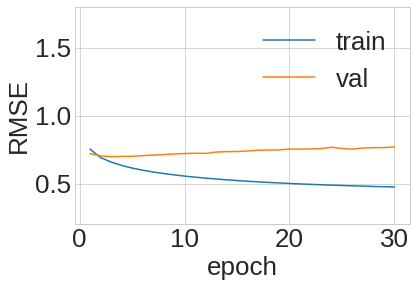

In [64]:
plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['legend.fontsize'] = 26
plt.style.use('seaborn-whitegrid')
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')
plt.ylabel('RMSE')
plt.ylim([0.2, 1.8])

plt.savefig(figure_path + '/' + dataset +'-large-loss.png', dpi=300, bbox_inches='tight')